In [1]:
# read code tools
# share in https://gist.github.com/WuShaogui/19c690bde2a0fe70b061d50e20129531
import sys
import os.path as osp
sys.path.append('/home/wushaogui/ReadCode/')
from my_read_code_tools import *

In [2]:
import cv2
import numpy as np
import json
import os.path as ops
from base64 import b64encode

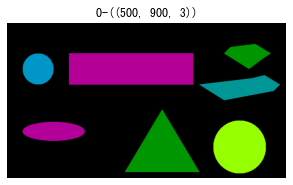

True

In [113]:
# 模拟图片
demoimage=np.zeros((500,900,3),np.uint8)
#cv2.line(demoimage,(15,15),(15,80),(0,255,0),10)
cv2.circle(demoimage,(100,150),50,(0,150,200),-1)
cv2.circle(demoimage,(750,400),85,(150,255,0),-1)

cv2.rectangle(demoimage,(200,100),(600,200),(180,0,150),-1)
cv2.ellipse(demoimage,(150,350),(100,30),0,0,360,(180,0,155),-1)

pts=np.array([[500, 280], [620, 480], [380, 480], [500, 280]], np.int32).reshape((-1, 1, 2))
cv2.fillPoly(demoimage, [pts], color=(0,150,0))

pts=np.array([[700, 100], [720, 80], [800, 70], [850, 100], [820, 120], [780, 150], [700, 100]], np.int32).reshape((-1, 1, 2))
cv2.fillPoly(demoimage, [pts], color=(0,150,0))

pts=np.array([[620, 200], [790, 180], [830, 170], [880, 200], [860, 220], [700, 250], [620, 200]], np.int32).reshape((-1, 1, 2))
cv2.fillPoly(demoimage, [pts], color=(0,150,150))
#cv2.polylines(demoimage,[pts],True,(0,255,0),0)

show_images([demoimage],nrows=1)
cv2.imwrite("images/demo_image.png",demoimage)

## 基于无markers的分水岭算法调用过程

基于无直接输入markers的场景，使用分水岭算法的过程，包括以下步骤
1. 通过二值化+开运算+distanceTransform生成“确定前景”区域
2. 通过二值化+膨胀生成“确定背景”区域
3. 全图-确定前景-确定背景=未知区域
4. 基于以上3个区域，生成markers

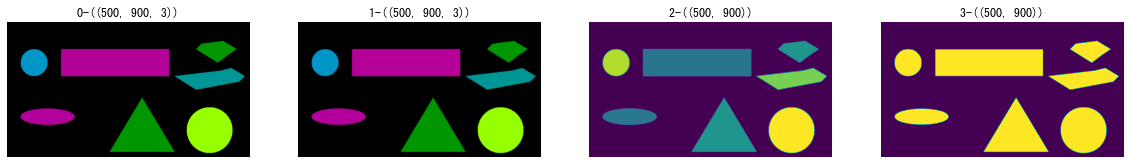

In [114]:
image=np.uint8(demoimage)
# 降噪
#blurred = cv2.pyrMeanShiftFiltering(image, 25, 100)
blurred = cv2.GaussianBlur(image, (3, 3), 0)
#blurred = cv2.blur(image, (5,5))

# 转为灰度图
gray=cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)

# 自适应二值化
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

show_images([image,blurred,gray,thresh],nrows=1)

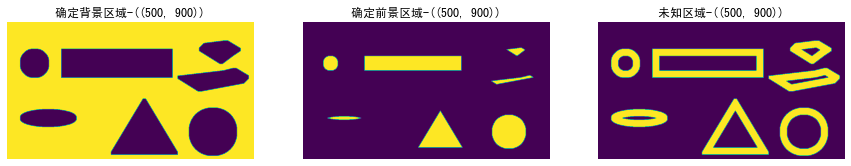

In [116]:
# ---------------------2.构造种子-----------------------------
# 开运算
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations =2) 
# sure_bg = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations =2) 

# 膨胀前景，剩下是确定的背景
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# 缩小前景，得到确定的前景
dist_transform = cv2.distanceTransform(sure_bg,cv2.DIST_L2,5)
dist_output = cv2.normalize(dist_transform, 0, 1.0, cv2.NORM_MINMAX) #归一化
ret, sure_fg = cv2.threshold(dist_output,0.3*dist_output.max(),255,0)

# 确定的背景-确定的前景，剩下部分是未知区域
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
show_images([sure_bg-255,sure_fg,unknown],nrows=1,titles=['确定背景区域','确定前景区域','未知区域'])

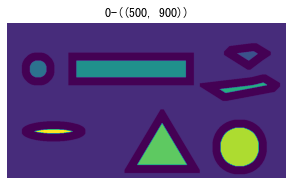

In [117]:
# 连通区域标记
ret, markers = cv2.connectedComponents(sure_fg)

# markers所有值+1，确保值从1开始
markers = markers+1

# 使用0值标记背景区域
markers[unknown==255]=0
show_images([markers],nrows=1)

[-1, 1, 2, 3, 4, 5, 6, 7, 8]


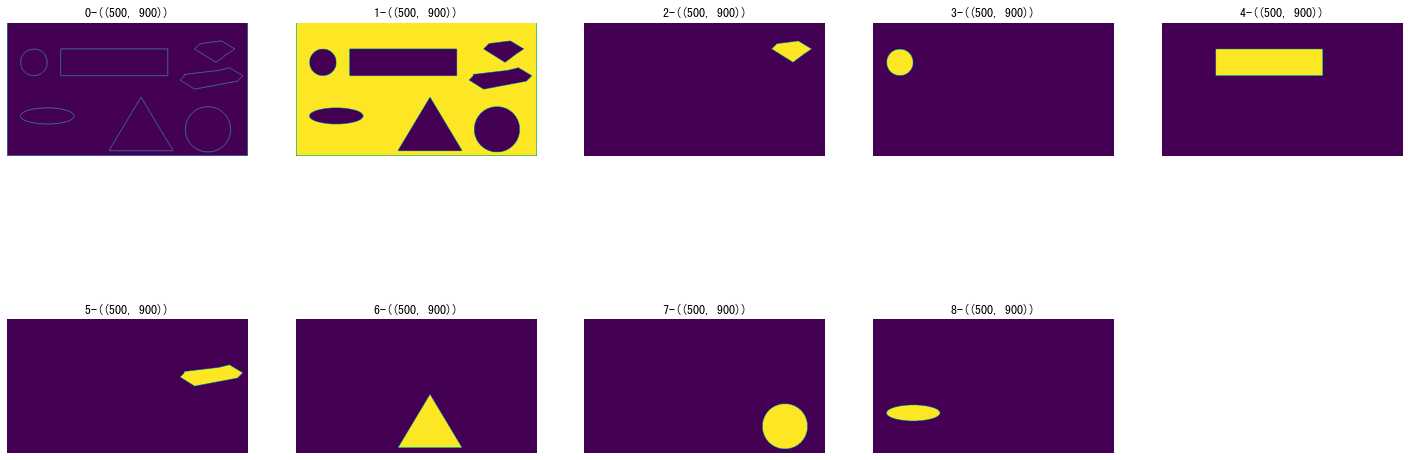

In [118]:
# 分水岭算法
markers = cv2.watershed(np.uint8(demoimage),markers)
indexs=list(np.unique(markers))
print(indexs)
show_images([markers==i for i in indexs],nrows=2)

## 基于有markers的分水岭算法封装

通过用户指定markers位置，或者配合界面使用鼠标指定位置，直接生成markers，然后直接使用分水岭算法

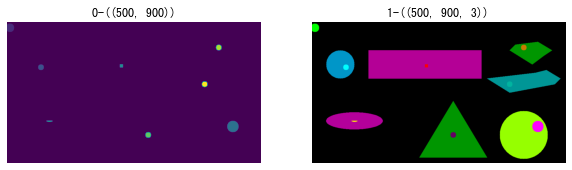

True

In [137]:
# 模拟标记
build_markers=np.zeros((500,900))

backgroupflag=1
flag1=2
flag2=3
flag3=4
flag4=5
flag5=6
flag6=7
flag7=8

# 必须同时给背景标记，否则无法分割
#flag1
cv2.circle(build_markers,(120,160),10,flag1,-1)
cv2.circle(build_markers,(800,370),20,flag2,-1)
#flag2
cv2.rectangle(build_markers,(400,150),(410,160),flag3,-1)
cv2.ellipse(build_markers,(150,350),(10,3),0,0,180,flag4,-1)
#flag13
cv2.circle(build_markers,(500,400),10,flag5,-1)
cv2.circle(build_markers,(750,90),10,flag6,-1)
#flag4
cv2.circle(build_markers,(700,220),10,flag7,-1)
#backgroup
cv2.circle(build_markers,(10,20),15,backgroupflag,-1) 

demoimage_copy=demoimage.copy()
demoimage_copy[build_markers ==flag1]=[0,255,255]
demoimage_copy[build_markers ==flag2]=[255,0,255]
demoimage_copy[build_markers ==flag3]=[255,0,0]
demoimage_copy[build_markers ==flag4]=[255,255,0]
demoimage_copy[build_markers ==flag5]=[100,0,100]
demoimage_copy[build_markers ==flag6]=[200,122,0]
demoimage_copy[build_markers ==flag7]=[0,180,160]
demoimage_copy[build_markers ==backgroupflag]=[0,255,0]


show_images([build_markers,demoimage_copy],nrows=1)
cv2.imwrite("images/demo_huaman.png",demoimage_copy)
cv2.imwrite("images/demo_markers.png",build_markers)

[-1, 1, 2, 3, 4, 5]


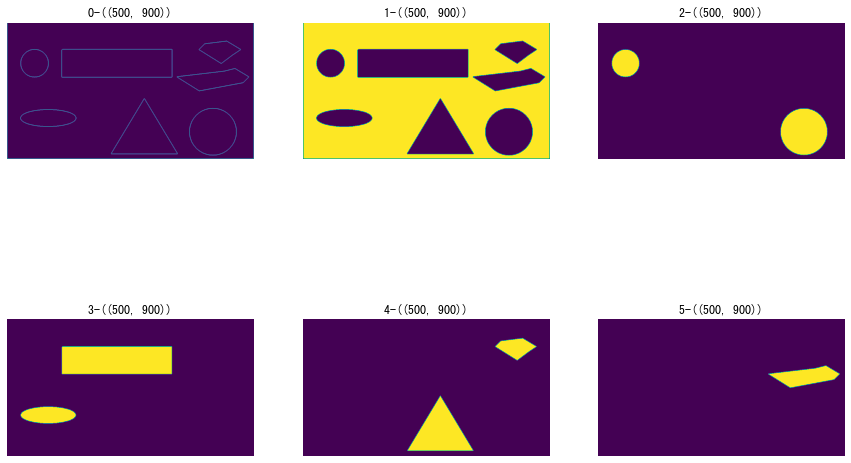

In [120]:
markers = cv2.watershed(demoimage.astype(np.uint8),build_markers.astype('int32'))
indexs=list(np.unique(markers))
print(indexs)
show_images([markers==i for i in indexs],nrows=2)

## 生成json

基于已知的二值图，生成labelme格式的json文件，主要方法的通过opencv提取二值图的轮廓点，然后按照labelme的json格式写进json文件

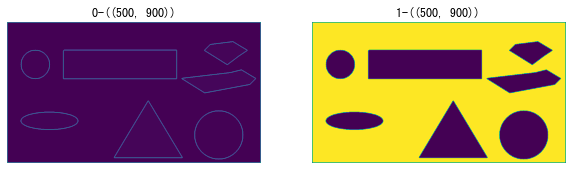

In [121]:
labels=np.unique(build_markers)

labelMask=labels[1]
markers_class=np.zeros((500,900))
markers_class[markers ==labelMask]=255
show_images([markers,markers_class],nrows=1)

In [122]:
# 加载json模板
save_json_path='./demoimage.json'
labelme_template = json.load(open('labelme4.5.7_template.json', 'r', encoding='utf-8'))
labelme_template['shapes'] = []
print(labelme_template)

{'version': '4.5.7', 'flags': {}, 'shapes_tree': [], 'shapes': [], 'imagePath': '', 'imageData': '', 'imageHeight': -1, 'imageWidth': -1}


In [123]:
def get_mask_shapes(mask,label='unnamed'):
    '''get_mask_shapes 解析mask的边缘点集

    Args:
        mask (2D array): mask数据
        min_points (int, optional): 最少的边缘点集. Defaults to 3.
        min_epsilon (int, optional): 点到边距离小于1，去掉该点. Defaults to 1.
        label (str, optional): 新生成边缘点集命名. Defaults to 'unnamed'.

    Returns:
        list(dict): 已经封装成json格式的边缘点集
    '''
    mask_shapes = []
    mask = mask.astype(np.uint8)
    mask = mask[..., -1] if len(mask.shape) == 3 else mask
    contours, _ = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # 原始mask

    for contour in contours:
        # 使用opencv求得近似多边形的点集合
        min_epsilon= 0.001 * cv2.arcLength(contour, True);
        new_contour = cv2.approxPolyDP(contour, min_epsilon, True)  
        new_contour = np.reshape(new_contour, (new_contour.shape[0], new_contour.shape[2]))

        # 过滤后的边点集数量在min_points以上
        if len(new_contour) > 0:
            shape = {}
            shape['label'] = label
            shape['points'] = []
            for point in new_contour:
                assert len(point.shape) == 1
                shape['points'].append(point.tolist())
            shape['group_id'] = None

            # 不同的形状，不同的解析方法，目前只能区分point，linestrip，polygon三种类型
            if len(shape['points']) == 1:
                shape['shape_type'] = 'point'
            elif len(shape['points']) == 2:
                shape['shape_type'] = 'linestrip'
            else:
                shape['shape_type'] = 'polygon'
            shape['flags'] = {}

            mask_shapes.append(shape)
        else:
            continue
    return mask_shapes

In [124]:
# 给json赋值
import copy

re_labelme_template = copy.deepcopy(labelme_template)
re_labelme_template['shapes'].extend(get_mask_shapes(markers_class,
                                                     label="{}".format(int(labelMask))))

# 修改json信息
re_labelme_template['imageHeight'] = demoimage.shape[0]
re_labelme_template['imageWidth'] = demoimage.shape[1]

rel_image_path = ops.join(ops.relpath('./', './'), 'images/demo_image.png')
re_labelme_template['imagePath'] = rel_image_path
re_labelme_template['imageData'] = b64encode(open('images/demo_image.png', "rb").read()).decode('utf-8')

In [125]:
# 保存json
json_content = json.dumps(re_labelme_template, ensure_ascii=False, indent=2, separators=(',', ': '))
with open(save_json_path, 'w+', encoding='utf-8') as fw:
    fw.write(json_content)

In [126]:
# 查看json内容
!head -n 15 {save_json_path}

{
  "version": "4.5.7",
  "flags": {},
  "shapes_tree": [],
  "shapes": [
    {
      "label": "1",
      "points": [
        [
          1,
          1
        ],
        [
          1,
          498


## 完整封装

将无markers和有markers的分水岭算法封装到一起，这就是完整的封装

- 输入：image,markers(可选）
- 输出：markers(多值图)

In [133]:
def watershedbydistant(image,markers=None):
    # 使用默认的方式构造种子
    if markers is  None:
        # ---------------------1.预处理-----------------------------
        blurred = cv2.GaussianBlur(image, (3, 3), 0)

        # 转为灰度图
        gray=cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)

        # 自适应二值化
        ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

        # ---------------------2.构造种子-----------------------------
        # 开运算
        kernel = np.ones((3,3),np.uint8)
        opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations =2) 
        # sure_bg = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations =2) 

        # 膨胀前景，剩下是确定的背景
        sure_bg = cv2.dilate(opening,kernel,iterations=3)

        # 缩小前景，得到确定的前景
        dist_transform = cv2.distanceTransform(sure_bg,cv2.DIST_L2,5)
        dist_output = cv2.normalize(dist_transform, 0, 1.0, cv2.NORM_MINMAX) #归一化
        ret, sure_fg = cv2.threshold(dist_output,0.3*dist_output.max(),255,0)

        # 确定的背景-确定的前景，剩下部分是未知区域
        sure_fg = np.uint8(sure_fg)
        unknown = cv2.subtract(sure_bg,sure_fg)
        # show_images([sure_bg-255,sure_fg,unknown],nrows=1,titles=['确定背景区域','确定前景区域','未知区域'])

        # 连通区域标记
        ret, markers = cv2.connectedComponents(sure_fg)

        # markers所有值+1，确保值从1开始
        markers = markers+1

        # 使用0值标记背景区域
        markers[unknown==255]=0
        # show_images([markers],nrows=1)
    else:
        # 认定传入的参数为种子
        print('共有{}种标记'.format(np.unique(markers)))
    
    # ---------------------3.使用分水岭算法-----------------------------
    markers = cv2.watershed(image,markers)
    
    return markers

## 测试

[-1, 1, 2, 3, 4, 5, 6, 7, 8]


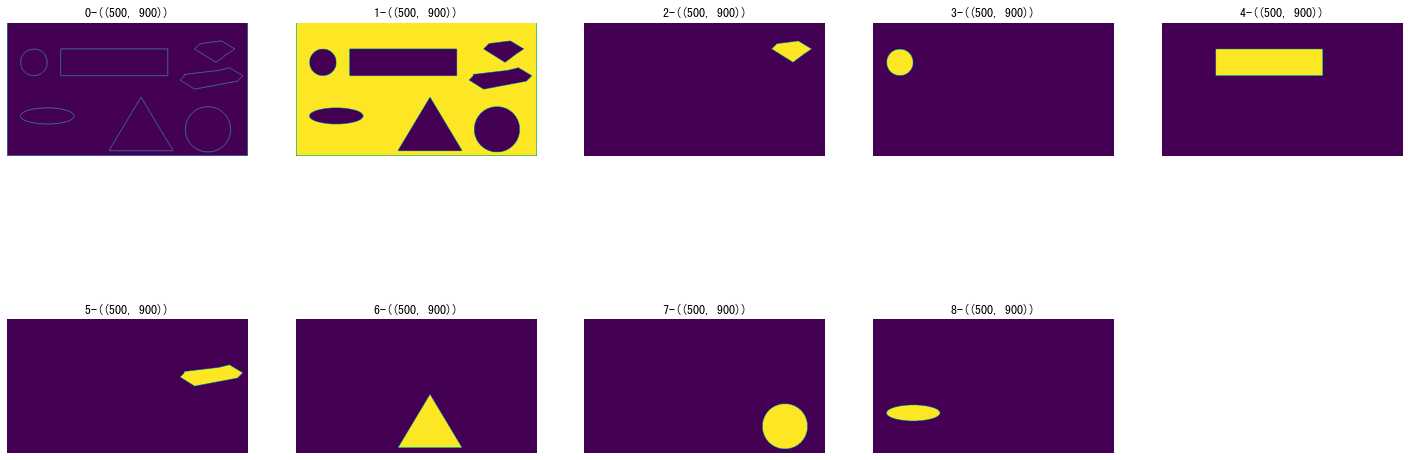

In [134]:
# 无markers调用过程
image_path='images/demo_image.png'
image=cv2.imread(image_path,1)

markers=watershedbydistant(image)
indexs=list(np.unique(markers))
print(indexs)
show_images([markers==i for i in indexs],nrows=2)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


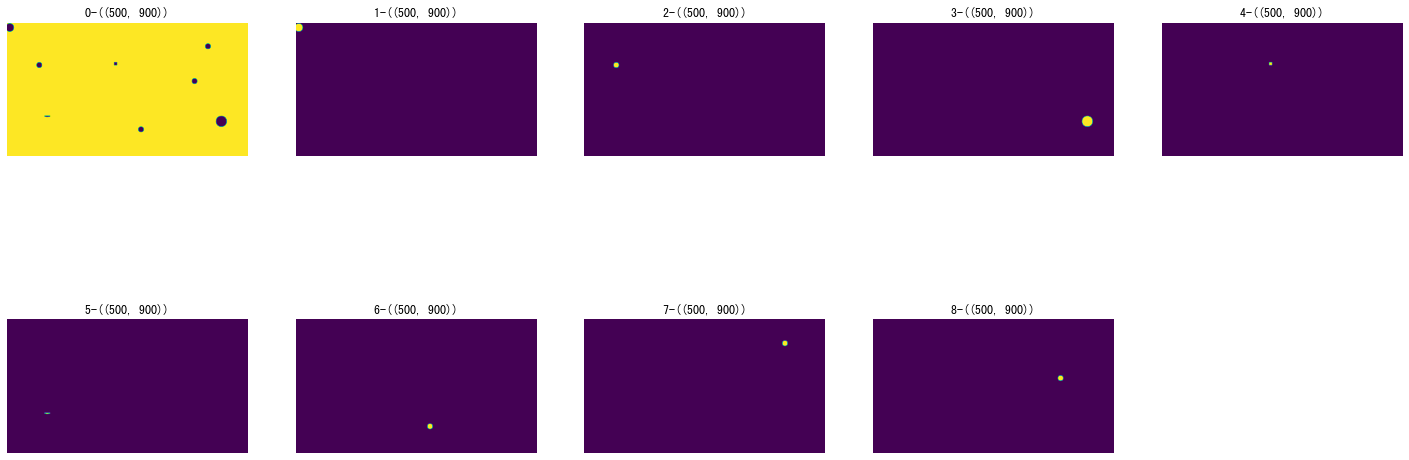

In [139]:
# 有markers调用过程
read_markers=cv2.imread("images/demo_markers.png",0) # 此处是直接读取markers
indexs=list(np.unique(read_markers))
print(indexs)
show_images([255*(read_markers==i) for i in indexs],nrows=2)

共有[0 1 2 3 4 5 6 7 8]种标记
[-1, 1, 2, 3, 4, 5, 6, 7, 8]


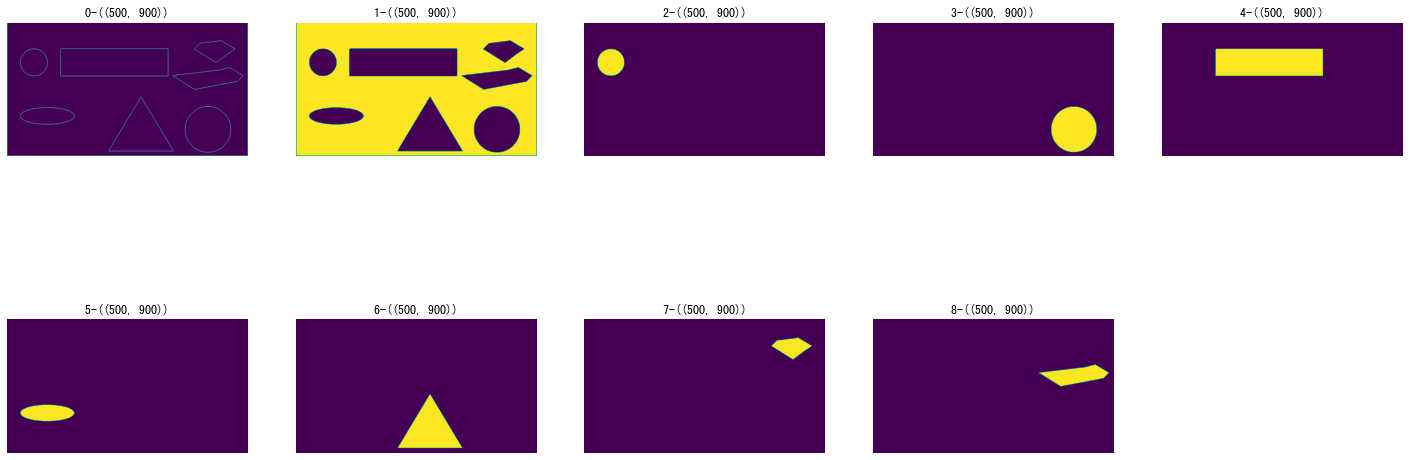

In [140]:
image_path='images/demo_image.png'
image=cv2.imread(image_path,1)
markers=watershedbydistant(image,markers=read_markers.astype(np.int32))
indexs=list(np.unique(markers))
print(indexs)
show_images([markers==i for i in indexs],nrows=2)

扩展

也可以将多个区域指定为一个目标，分水岭算法直接分割为同一目标

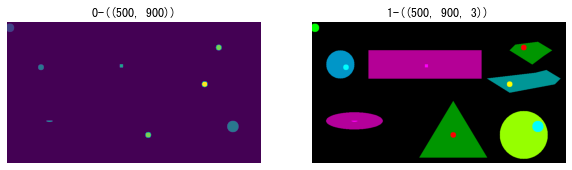

True

In [141]:
# 模拟标记
build_markers=np.zeros((500,900))

backgroupflag=1
flag1=2
flag2=3
flag3=4
flag4=5

# 必须同时给背景标记，否则无法分割
#flag1
cv2.circle(build_markers,(120,160),10,flag1,-1)
cv2.circle(build_markers,(800,370),20,flag1,-1)
#flag2
cv2.rectangle(build_markers,(400,150),(410,160),flag2,-1)
cv2.ellipse(build_markers,(150,350),(10,3),0,0,180,flag2,-1)
#flag13
cv2.circle(build_markers,(500,400),10,flag3,-1)
cv2.circle(build_markers,(750,90),10,flag3,-1)
#flag4
cv2.circle(build_markers,(700,220),10,flag4,-1)
#backgroup
cv2.circle(build_markers,(10,20),15,backgroupflag,-1) 

demoimage_copy=demoimage.copy()
demoimage_copy[build_markers ==flag1]=[0,255,255]
demoimage_copy[build_markers ==flag2]=[255,0,255]
demoimage_copy[build_markers ==flag3]=[255,0,0]
demoimage_copy[build_markers ==flag4]=[255,255,0]
demoimage_copy[build_markers ==backgroupflag]=[0,255,0]

show_images([build_markers,demoimage_copy],nrows=1)
cv2.imwrite("images/demo_huaman-1.png",demoimage_copy)
cv2.imwrite("images/demo_markers-1.png",build_markers)

[0, 1, 2, 3, 4, 5]


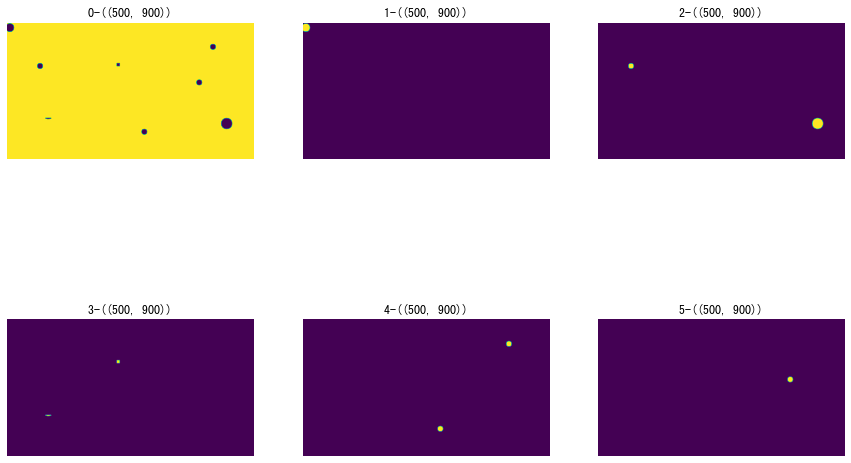

In [142]:
# 有markers调用过程
read_markers=cv2.imread("images/demo_markers-1.png",0) # 此处是直接读取markers
indexs=list(np.unique(read_markers))
print(indexs)
show_images([255*(read_markers==i) for i in indexs],nrows=2)

共有[0 1 2 3 4 5]种标记
[-1, 1, 2, 3, 4, 5]


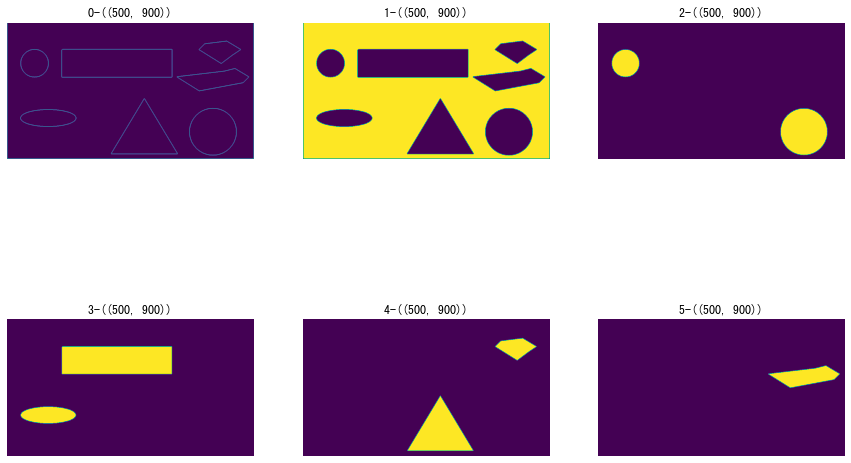

In [143]:
image_path='images/demo_image.png'
image=cv2.imread(image_path,1)
markers=watershedbydistant(image,markers=read_markers.astype(np.int32))
indexs=list(np.unique(markers))
print(indexs)
show_images([markers==i for i in indexs],nrows=2)